Apply PCA to reduce dimensionality in modeling net migration into US counties.

Data come from [US Census](https://bit.ly/38PyfmR)

In [1]:
%run ./mobilityHelpers.ipynb
helpers = mobilityHelpers()

gdpFile = helpers.mFiles["gdp"]
piFile = helpers.mFiles["pi"]
hhiFile = helpers.mFiles["hhi"]
populationFile = helpers.mFiles["pop"]
suicideFile = helpers.mFiles["sc"]

C:\Users\alexg\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
popDF, popDFlong = helpers.getPopulationDynamicsData()
popDF.head()
popDFlong.head()

,state,county,county_state,value,year,metric
0,Alabama,Autauga,"Autauga, Alabama",54571.0,2010,CENSUSPOP
1,Alabama,Baldwin,"Baldwin, Alabama",182265.0,2010,CENSUSPOP
2,Alabama,Barbour,"Barbour, Alabama",27457.0,2010,CENSUSPOP
3,Alabama,Bibb,"Bibb, Alabama",22915.0,2010,CENSUSPOP
4,Alabama,Blount,"Blount, Alabama",57322.0,2010,CENSUSPOP


In [3]:
gdpDF, gdpDFlong = helpers.getGDPdata()
gdpDF.head()
gdpDFlong.tail()

,county,state,value,year,metric,county_state
24835,Sweetwater,Wyoming,6.583947,2018,GDP_LOG,"Sweetwater, Wyoming"
24836,Teton,Wyoming,6.335743,2018,GDP_LOG,"Teton, Wyoming"
24837,Uinta,Wyoming,5.957409,2018,GDP_LOG,"Uinta, Wyoming"
24838,Washakie,Wyoming,5.554009,2018,GDP_LOG,"Washakie, Wyoming"
24839,Weston,Wyoming,5.499529,2018,GDP_LOG,"Weston, Wyoming"


In [4]:
%run ./mobilityHelpers.ipynb
helpers = mobilityHelpers()
hhiDF, hhiDFlong = helpers.getHouseholdIncomeData()
hhiDFlong.head()

,county,state,county_state,year,value,metric
0,Jersey,Illinois,"Jersey, Illinois",2010,1.173144,mean_to_median_household_income_ratio
1,Jo Daviess,Illinois,"Jo Daviess, Illinois",2010,1.224985,mean_to_median_household_income_ratio
2,Johnson,Illinois,"Johnson, Illinois",2010,1.163771,mean_to_median_household_income_ratio
3,Kane,Illinois,"Kane, Illinois",2010,1.274337,mean_to_median_household_income_ratio
4,Kankakee,Illinois,"Kankakee, Illinois",2010,1.208422,mean_to_median_household_income_ratio


In [5]:
%run ./mobilityHelpers.ipynb
helpers = mobilityHelpers()
scDF, scDFlong = helpers.getSuicideRateData()
# scDFlong.rename(columns={"variable": "metric"}, inplace=True)
scDFlong.head()


,county,state,county_state,year,metric,value
0,Baldwin,Alabama,"Baldwin, Alabama",2006,SCRATE,18.3
1,Calhoun,Alabama,"Calhoun, Alabama",2006,SCRATE,18.1
2,Jefferson,Alabama,"Jefferson, Alabama",2006,SCRATE,10.9
3,Madison,Alabama,"Madison, Alabama",2006,SCRATE,13.9
4,Mobile,Alabama,"Mobile, Alabama",2006,SCRATE,9.8


In [6]:
"""
concatenate hhi, gdp, pop, and sc
"""
hhi_gdp_pop_sc_long = pd.concat([gdpDFlong, hhiDFlong, popDFlong, scDFlong], sort=True).reset_index(drop=True)
hhi_gdp_pop_sc_long.head()

,county,county_state,metric,state,value,year
0,Autauga,"Autauga, Alabama",GDP,Alabama,1518409.0,2015
1,Baldwin,"Baldwin, Alabama",GDP,Alabama,5345363.0,2015
2,Barbour,"Barbour, Alabama",GDP,Alabama,756590.0,2015
3,Bibb,"Bibb, Alabama",GDP,Alabama,358372.0,2015
4,Blount,"Blount, Alabama",GDP,Alabama,824934.0,2015


In [7]:
hhi_gdp_pop_sc_long.tail()

,county,county_state,metric,state,value,year
562922,Rock,"Rock, Wisconsin",SC_R_DEATH,Wisconsin,20.842401,2018
562923,Waukesha,"Waukesha, Wisconsin",SC_R_DEATH,Wisconsin,14.885678,2018
562924,Winnebago,"Winnebago, Wisconsin",SC_R_DEATH,Wisconsin,21.050170,2018
562925,Laramie,"Laramie, Wyoming",SC_R_DEATH,Wyoming,34.351762,2018
562926,Natrona,"Natrona, Wyoming",SC_R_DEATH,Wyoming,34.127536,2018


Now we have all the data: population dynamics (modeled by US Census Bureau); GDP; Household Income, and Suicide Rates.  Next we will apply ML methods to extract insights from these data.

In [8]:
hhi_gdp_pop_sc_long["metric_year"] = hhi_gdp_pop_sc_long["metric"] + hhi_gdp_pop_sc_long["year"].astype("str")
hhi_gdp_pop_sc_df = hhi_gdp_pop_sc_long.pivot_table(index=["county_state"],
                                                    columns=["metric_year"],
                                                    values=["value"]).reset_index(drop=False)
cols = ["county_state"]
cols.extend(list(hhi_gdp_pop_sc_df.columns.levels[1][:-1]))
hhi_gdp_pop_sc_df.columns = cols
hhi_gdp_pop_sc_df.dropna(inplace=True)

hhi_gdp_pop_sc_df.reset_index(drop=True, inplace=True)

print(hhi_gdp_pop_sc_df.dtypes)

hhi_gdp_pop_sc_df.head()

county_state                   object
BIRTHS2010                    float64
BIRTHS2011                    float64
BIRTHS2012                    float64
BIRTHS2013                    float64
                               ...   
median_income__dollars2014    float64
median_income__dollars2015    float64
median_income__dollars2016    float64
median_income__dollars2017    float64
median_income__dollars2018    float64
Length: 224, dtype: object


,county_state,BIRTHS2010,BIRTHS2011,BIRTHS2012,BIRTHS2013,BIRTHS2014,BIRTHS2015,BIRTHS2016,BIRTHS2017,BIRTHS2018,...,mean_to_median_household_income_ratio2018,median_income__dollars2010,median_income__dollars2011,median_income__dollars2012,median_income__dollars2013,median_income__dollars2014,median_income__dollars2015,median_income__dollars2016,median_income__dollars2017,median_income__dollars2018
0,"Ada, Idaho",1310.0,5150.0,5032.0,5043.0,4986.0,5186.0,5074.0,4937.0,4946.0,...,1.342082,55835.0,55304.0,55499.0,55210.0,55805.0,56356.0,58099.0,60151.0,63137.0
1,"Adams, Colorado",1806.0,7294.0,6922.0,7168.0,7040.0,7370.0,7239.0,7102.0,7008.0,...,1.233711,54666.0,56089.0,56633.0,56270.0,57421.0,58946.0,61444.0,64087.0,67575.0
2,"Alachua, Florida",695.0,2824.0,3001.0,2822.0,2883.0,2911.0,2875.0,2815.0,2801.0,...,1.432597,40644.0,41373.0,42818.0,42149.0,42045.0,43073.0,44702.0,45478.0,49078.0
3,"Alameda, California",4879.0,19220.0,18979.0,19469.0,19496.0,19489.0,19503.0,19594.0,18497.0,...,1.324076,69384.0,70821.0,71516.0,72112.0,73775.0,75619.0,79831.0,85743.0,92574.0
4,"Allegheny, Pennsylvania",3356.0,13167.0,13105.0,13165.0,13063.0,13175.0,13286.0,13086.0,12859.0,...,1.417348,47961.0,49805.0,50664.0,51366.0,52390.0,53040.0,54357.0,56333.0,58383.0


In [9]:
yy=2010
yyDF = hhi_gdp_pop_sc_df[[cc for cc in hhi_gdp_pop_sc_df if str(yy) in cc]].copy()
for cc in yyDF.columns:
    yyDF[cc] = yyDF[cc].astype("float64")
yyDF.columns

Index(['BIRTHS2010', 'CENSUSPOP2010', 'DEATHS2010', 'DOMESTICMIG2010',
       'ESTIMATESBASE2010', 'INTERNATIONALMIG2010', 'NATURALINC2010',
       'NETMIG2010', 'NPOPCHG_2010', 'POPESTIMATE2010', 'POP_CDC2010',
       'SCDEATHS2010', 'SCRATE2010', 'SC_R_DEATH2010',
       'mean_income__dollars2010', 'mean_to_median_household_income_ratio2010',
       'median_income__dollars2010'],
      dtype='object')

Analyze correlations.  The machine does not need our visualizations, but it's good to see them to check how well it did.  In the plot below, the numbers on the X and Y axes represent the index of the corresponding column in the dataframe

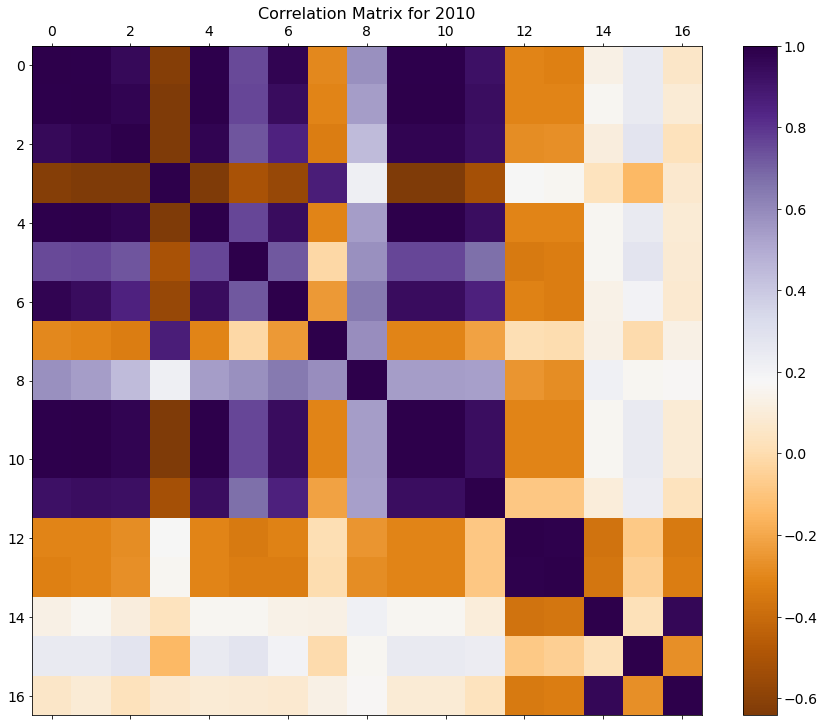

0: BIRTHS2010
1: CENSUSPOP2010
2: DEATHS2010
3: DOMESTICMIG2010
4: ESTIMATESBASE2010
5: INTERNATIONALMIG2010
6: NATURALINC2010
7: NETMIG2010
8: NPOPCHG_2010
9: POPESTIMATE2010
10: POP_CDC2010
11: SCDEATHS2010
12: SCRATE2010
13: SC_R_DEATH2010
14: mean_income__dollars2010
15: mean_to_median_household_income_ratio2010
16: median_income__dollars2010


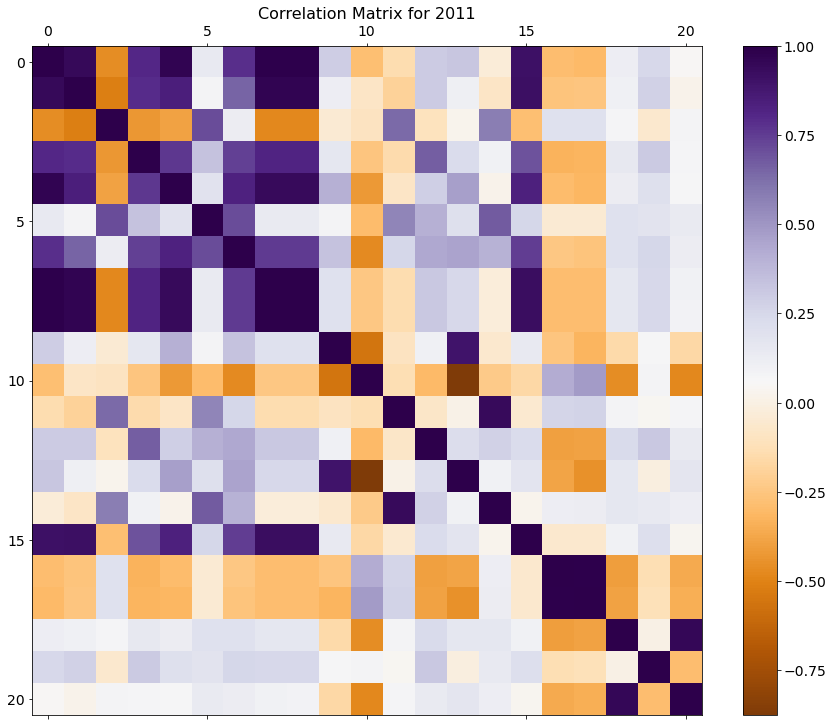

0: BIRTHS2011
1: DEATHS2011
2: DOMESTICMIG2011
3: INTERNATIONALMIG2011
4: NATURALINC2011
5: NETMIG2011
6: NPOPCHG_2011
7: POPESTIMATE2011
8: POP_CDC2011
9: RBIRTH2011
10: RDEATH2011
11: RDOMESTICMIG2011
12: RINTERNATIONALMIG2011
13: RNATURALINC2011
14: RNETMIG2011
15: SCDEATHS2011
16: SCRATE2011
17: SC_R_DEATH2011
18: mean_income__dollars2011
19: mean_to_median_household_income_ratio2011
20: median_income__dollars2011


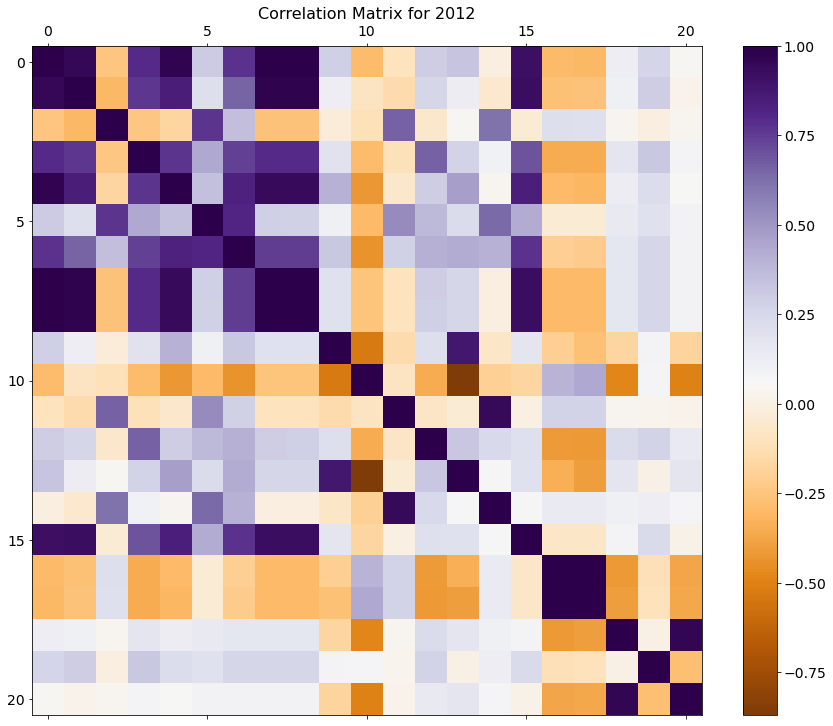

0: BIRTHS2012
1: DEATHS2012
2: DOMESTICMIG2012
3: INTERNATIONALMIG2012
4: NATURALINC2012
5: NETMIG2012
6: NPOPCHG_2012
7: POPESTIMATE2012
8: POP_CDC2012
9: RBIRTH2012
10: RDEATH2012
11: RDOMESTICMIG2012
12: RINTERNATIONALMIG2012
13: RNATURALINC2012
14: RNETMIG2012
15: SCDEATHS2012
16: SCRATE2012
17: SC_R_DEATH2012
18: mean_income__dollars2012
19: mean_to_median_household_income_ratio2012
20: median_income__dollars2012


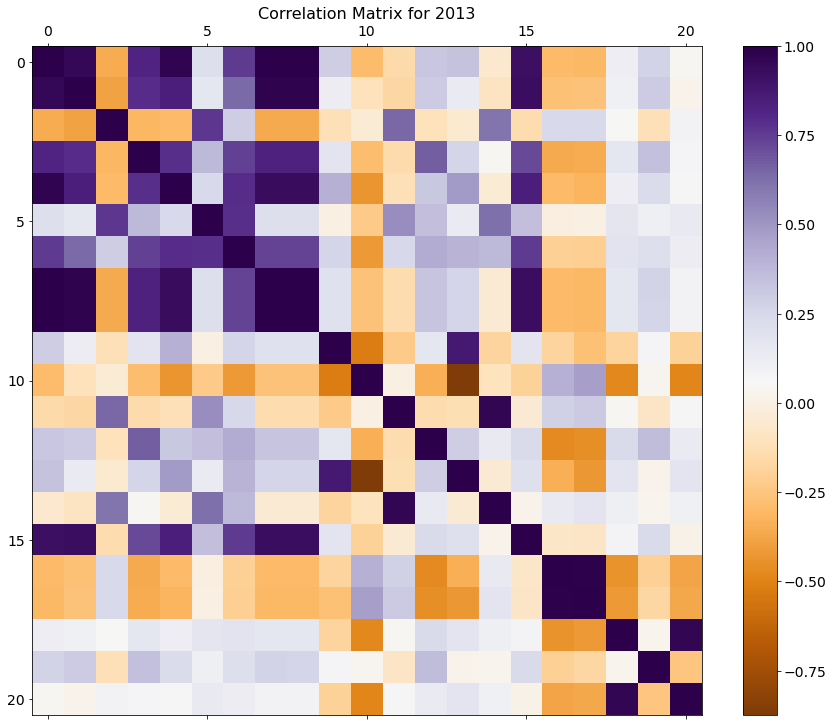

0: BIRTHS2013
1: DEATHS2013
2: DOMESTICMIG2013
3: INTERNATIONALMIG2013
4: NATURALINC2013
5: NETMIG2013
6: NPOPCHG_2013
7: POPESTIMATE2013
8: POP_CDC2013
9: RBIRTH2013
10: RDEATH2013
11: RDOMESTICMIG2013
12: RINTERNATIONALMIG2013
13: RNATURALINC2013
14: RNETMIG2013
15: SCDEATHS2013
16: SCRATE2013
17: SC_R_DEATH2013
18: mean_income__dollars2013
19: mean_to_median_household_income_ratio2013
20: median_income__dollars2013


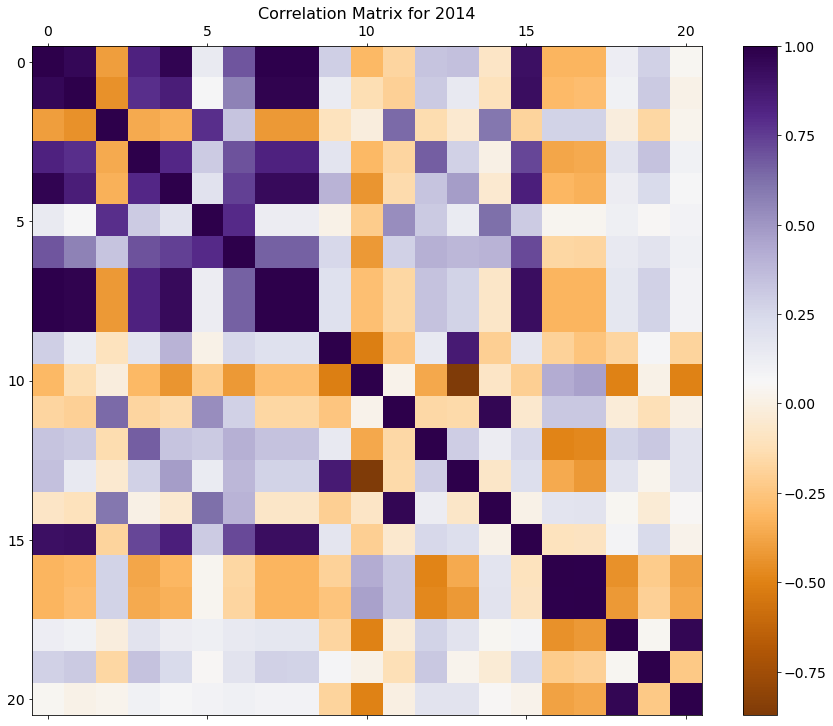

0: BIRTHS2014
1: DEATHS2014
2: DOMESTICMIG2014
3: INTERNATIONALMIG2014
4: NATURALINC2014
5: NETMIG2014
6: NPOPCHG_2014
7: POPESTIMATE2014
8: POP_CDC2014
9: RBIRTH2014
10: RDEATH2014
11: RDOMESTICMIG2014
12: RINTERNATIONALMIG2014
13: RNATURALINC2014
14: RNETMIG2014
15: SCDEATHS2014
16: SCRATE2014
17: SC_R_DEATH2014
18: mean_income__dollars2014
19: mean_to_median_household_income_ratio2014
20: median_income__dollars2014


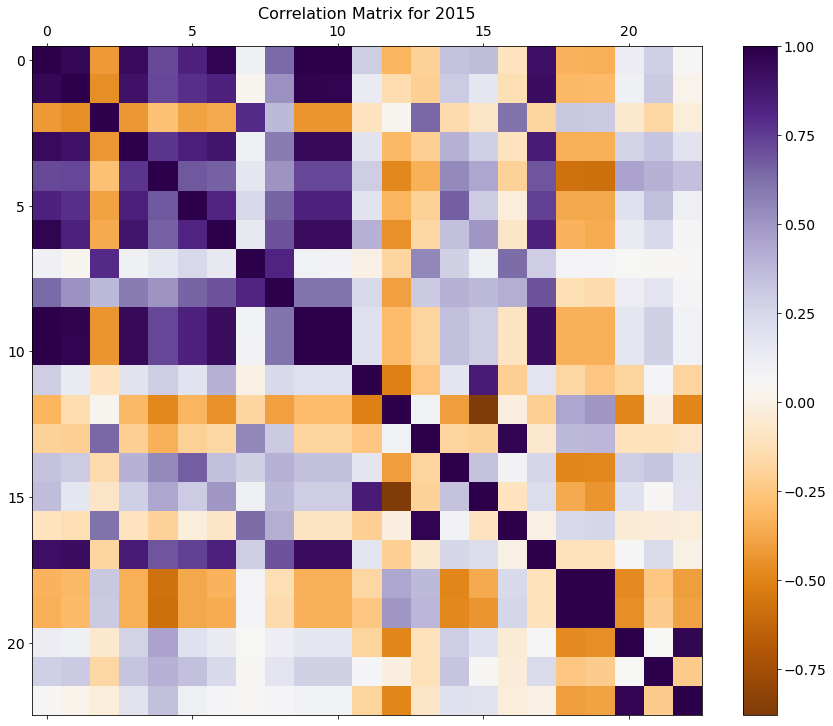

0: BIRTHS2015
1: DEATHS2015
2: DOMESTICMIG2015
3: GDP2015
4: GDP_LOG2015
5: INTERNATIONALMIG2015
6: NATURALINC2015
7: NETMIG2015
8: NPOPCHG_2015
9: POPESTIMATE2015
10: POP_CDC2015
11: RBIRTH2015
12: RDEATH2015
13: RDOMESTICMIG2015
14: RINTERNATIONALMIG2015
15: RNATURALINC2015
16: RNETMIG2015
17: SCDEATHS2015
18: SCRATE2015
19: SC_R_DEATH2015
20: mean_income__dollars2015
21: mean_to_median_household_income_ratio2015
22: median_income__dollars2015


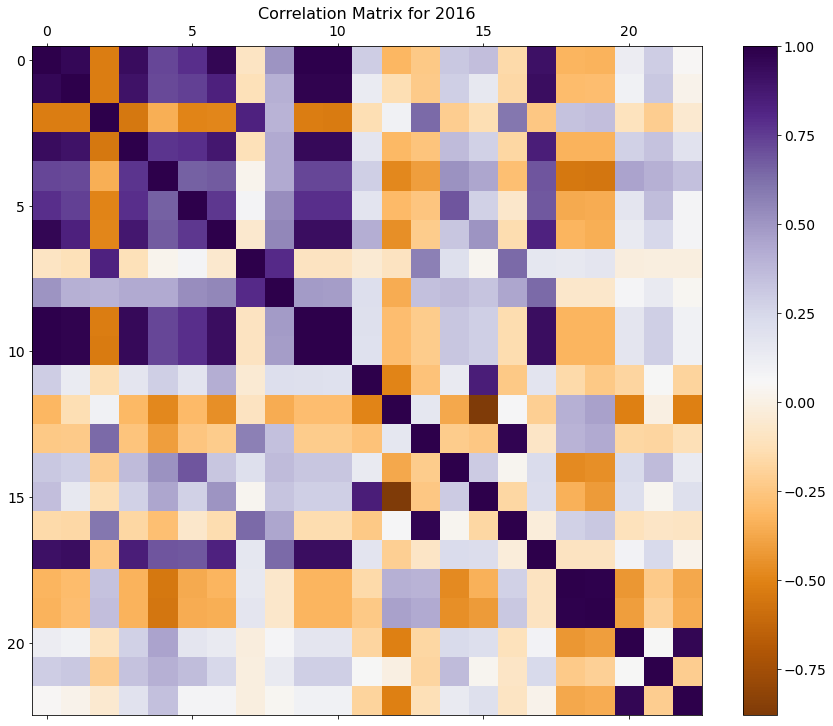

0: BIRTHS2016
1: DEATHS2016
2: DOMESTICMIG2016
3: GDP2016
4: GDP_LOG2016
5: INTERNATIONALMIG2016
6: NATURALINC2016
7: NETMIG2016
8: NPOPCHG_2016
9: POPESTIMATE2016
10: POP_CDC2016
11: RBIRTH2016
12: RDEATH2016
13: RDOMESTICMIG2016
14: RINTERNATIONALMIG2016
15: RNATURALINC2016
16: RNETMIG2016
17: SCDEATHS2016
18: SCRATE2016
19: SC_R_DEATH2016
20: mean_income__dollars2016
21: mean_to_median_household_income_ratio2016
22: median_income__dollars2016


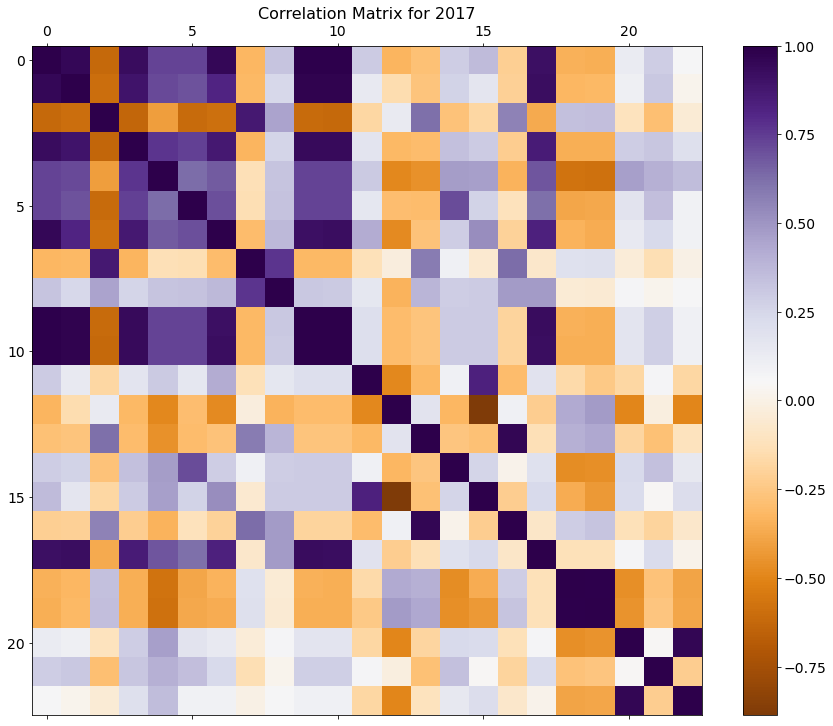

0: BIRTHS2017
1: DEATHS2017
2: DOMESTICMIG2017
3: GDP2017
4: GDP_LOG2017
5: INTERNATIONALMIG2017
6: NATURALINC2017
7: NETMIG2017
8: NPOPCHG_2017
9: POPESTIMATE2017
10: POP_CDC2017
11: RBIRTH2017
12: RDEATH2017
13: RDOMESTICMIG2017
14: RINTERNATIONALMIG2017
15: RNATURALINC2017
16: RNETMIG2017
17: SCDEATHS2017
18: SCRATE2017
19: SC_R_DEATH2017
20: mean_income__dollars2017
21: mean_to_median_household_income_ratio2017
22: median_income__dollars2017


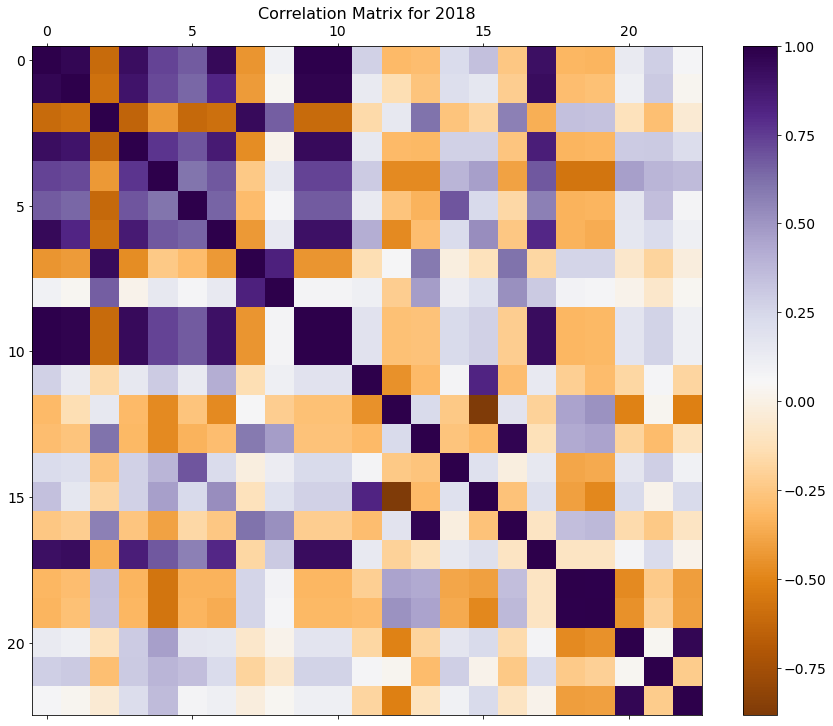

0: BIRTHS2018
1: DEATHS2018
2: DOMESTICMIG2018
3: GDP2018
4: GDP_LOG2018
5: INTERNATIONALMIG2018
6: NATURALINC2018
7: NETMIG2018
8: NPOPCHG_2018
9: POPESTIMATE2018
10: POP_CDC2018
11: RBIRTH2018
12: RDEATH2018
13: RDOMESTICMIG2018
14: RINTERNATIONALMIG2018
15: RNATURALINC2018
16: RNETMIG2018
17: SCDEATHS2018
18: SCRATE2018
19: SC_R_DEATH2018
20: mean_income__dollars2018
21: mean_to_median_household_income_ratio2018
22: median_income__dollars2018


In [10]:
%run ./mobilityHelpers.ipynb
helpers = mobilityHelpers()

for yy in range(2010, 2019):
    yyDF = hhi_gdp_pop_sc_df[[cc for cc in hhi_gdp_pop_sc_df if str(yy) in cc]].copy()
    #     for cc in yyDF.columns:
    #         yyDF[cc] = yyDF[cc].astype("float64")
    helpers.plotCorrMatrix(yyDF, "Correlation Matrix for " + str(yy))
    for ii in range(len(yyDF.columns)):
        print(f"""{ii}: {list(yyDF.columns)[ii]}""")


In every year, there is a lot of multicollinearity.  

For some pairs of variables, it is expected mathematically: e.g., US Census population counts are measured only once in 10 years, and then model the rest based on migration and birth/death dynamics.  Suicide deaths ("SCDEATHS" in our dataset) will be correlated with death counts collected by the Census Bureau for each year ("DEATHS" in our dataset) and with suicide rate ("SCRATE").  Mean Household Income will be correlated with Median Household Income, although that correlation will vary by county.

For others, it is not expected mathematically, but logically sound: e.g., in 2018, suicide attempt rate ("SCRATE", variable 18) is strongly negatively correlated with mean (variable 20) and median household income (variable 22) and to a lesser degree with the economic disparity measured as "mean_to_median_household_income_ratio" (variable 21).

For still others, we have some surprises:  e.g., in 2018, suicide deaths ("SCDEATHS", variable 17) are positively correlated with domestic migration into the county ("DOMESTICMIG", variable 2) and with GDP (variable 3); at the same time these relationships are opposite for suicide attempt rate ("SCRATE", variable 18) and for suicide death rate ("SC_R_DEATH", variable 19).

Our variable of interest, net migration into the county ("NETMIG", variable 7), is very strongly positively correlated with GDP (variable 3) and very mildly negatively correlated with household income disparity (variable 18).  Interestingly, it is also negatively correlated with international migration into the county ("INTERNATIONALMIG", variable 5), number of births in the county ("BIRTHS", variable 0), and household income (variables 17 and 19) in the target county and positively with domestic migration ("DOMESTICMIG", variable 2).

***TODO: Express verbally what else we see in the correlation matrix plots***

To avoid data leakage and perfect accuracy (meaning model is overfitted), we need to do the following:

1. Perform PCA to combine variables into principal components
2. Identify top N principal components based on their contribution to variance (CTV)
3. Build predictive models

In [11]:
hhi_gdp_pop_sc_long.head()

,county,county_state,metric,state,value,year,metric_year
0,Autauga,"Autauga, Alabama",GDP,Alabama,1518409.0,2015,GDP2015
1,Baldwin,"Baldwin, Alabama",GDP,Alabama,5345363.0,2015,GDP2015
2,Barbour,"Barbour, Alabama",GDP,Alabama,756590.0,2015,GDP2015
3,Bibb,"Bibb, Alabama",GDP,Alabama,358372.0,2015,GDP2015
4,Blount,"Blount, Alabama",GDP,Alabama,824934.0,2015,GDP2015


Do the same correlation analysis including the year:

In [12]:
# del hhi_gdp_pop_sc_long["metric_year"]
hhi_gdp_pop_sc_yr_df = hhi_gdp_pop_sc_long.pivot_table(index=["county_state", "year"],
                                                    columns=["metric"],
                                                    values=["value"]).reset_index(drop=False)
cols = ["county_state"]
cols.extend(["year"])
cols.extend(list(hhi_gdp_pop_sc_yr_df.columns.levels[1][:-1]))


hhi_gdp_pop_sc_yr_df.columns = cols

hhi_gdp_pop_sc_yr_df.year = hhi_gdp_pop_sc_yr_df.year.astype("float64")
hhi_gdp_pop_sc_yr_df.reset_index(drop=True, inplace=True)

print(hhi_gdp_pop_sc_yr_df.dtypes)

hhi_gdp_pop_sc_yr_df.head()

county_state                              object
year                                     float64
BIRTHS                                   float64
CENSUSPOP                                float64
DEATHS                                   float64
DOMESTICMIG                              float64
ESTIMATESBASE                            float64
GDP                                      float64
GDP_LOG                                  float64
INTERNATIONALMIG                         float64
NATURALINC                               float64
NETMIG                                   float64
NPOPCHG_                                 float64
POPESTIMATE                              float64
POP_CDC                                  float64
RBIRTH                                   float64
RDEATH                                   float64
RDOMESTICMIG                             float64
RINTERNATIONALMIG                        float64
RNATURALINC                              float64
RNETMIG             

,county_state,year,BIRTHS,CENSUSPOP,DEATHS,DOMESTICMIG,ESTIMATESBASE,GDP,GDP_LOG,INTERNATIONALMIG,...,RDOMESTICMIG,RINTERNATIONALMIG,RNATURALINC,RNETMIG,SCDEATHS,SCRATE,SC_R_DEATH,mean_income__dollars,mean_to_median_household_income_ratio,median_income__dollars
0,"Abbeville, South Carolina",2010.0,65.0,25417.0,90.0,-67.0,25416.0,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41816.0,1.261684,33143.0
1,"Abbeville, South Carolina",2011.0,229.0,NaN,290.0,-192.0,NaN,NaN,NaN,6.0,...,-7.617687,0.238053,-2.420203,-7.379635,NaN,NaN,NaN,43780.0,1.262763,34670.0
2,"Abbeville, South Carolina",2012.0,280.0,NaN,252.0,-106.0,NaN,NaN,NaN,18.0,...,-4.231537,0.718563,1.117764,-3.512974,NaN,NaN,NaN,44676.0,1.274018,35067.0
3,"Abbeville, South Carolina",2013.0,273.0,NaN,278.0,-113.0,NaN,NaN,NaN,0.0,...,-4.527425,0.000000,-0.200329,-4.527425,NaN,NaN,NaN,45632.0,1.269424,35947.0
4,"Abbeville, South Carolina",2014.0,242.0,NaN,261.0,-76.0,NaN,NaN,NaN,-6.0,...,-3.058719,-0.241478,-0.764680,-3.300197,NaN,NaN,NaN,45773.0,1.292694,35409.0


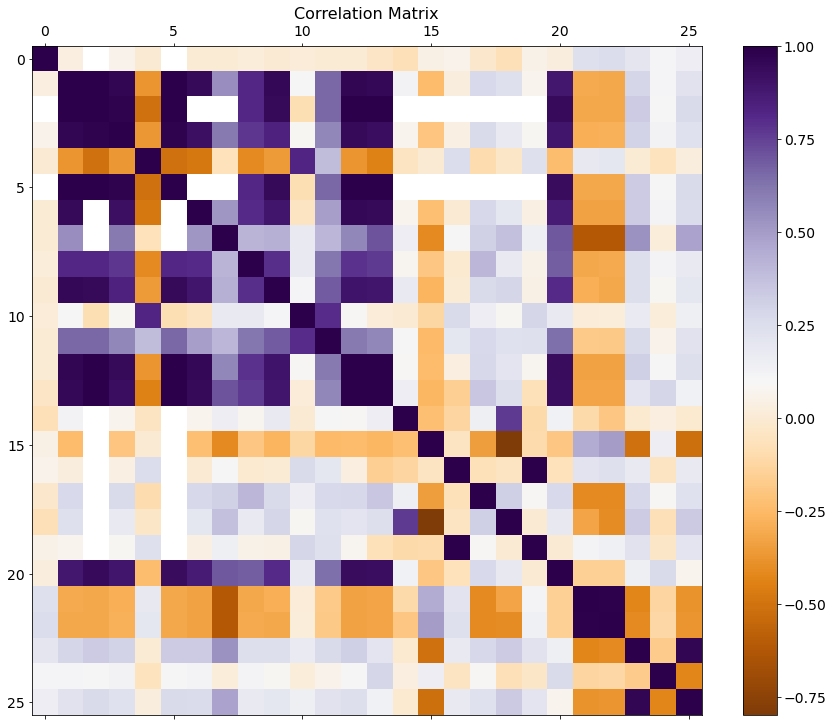

0: year
1: BIRTHS
2: CENSUSPOP
3: DEATHS
4: DOMESTICMIG
5: ESTIMATESBASE
6: GDP
7: GDP_LOG
8: INTERNATIONALMIG
9: NATURALINC
10: NETMIG
11: NPOPCHG_
12: POPESTIMATE
13: POP_CDC
14: RBIRTH
15: RDEATH
16: RDOMESTICMIG
17: RINTERNATIONALMIG
18: RNATURALINC
19: RNETMIG
20: SCDEATHS
21: SCRATE
22: SC_R_DEATH
23: mean_income__dollars
24: mean_to_median_household_income_ratio
25: median_income__dollars


,year,BIRTHS,CENSUSPOP,DEATHS,DOMESTICMIG,ESTIMATESBASE,GDP,GDP_LOG,INTERNATIONALMIG,NATURALINC,...,RDOMESTICMIG,RINTERNATIONALMIG,RNATURALINC,RNETMIG,SCDEATHS,SCRATE,SC_R_DEATH,mean_income__dollars,mean_to_median_household_income_ratio,median_income__dollars
0,2010.0,65.0,25417.0,90.0,-67.0,25416.0,NaN,NaN,2.0,-25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41816.0,1.261684,33143.0
1,2011.0,229.0,NaN,290.0,-192.0,NaN,NaN,NaN,6.0,-61.0,...,-7.617687,0.238053,-2.420203,-7.379635,NaN,NaN,NaN,43780.0,1.262763,34670.0
2,2012.0,280.0,NaN,252.0,-106.0,NaN,NaN,NaN,18.0,28.0,...,-4.231537,0.718563,1.117764,-3.512974,NaN,NaN,NaN,44676.0,1.274018,35067.0
3,2013.0,273.0,NaN,278.0,-113.0,NaN,NaN,NaN,0.0,-5.0,...,-4.527425,0.000000,-0.200329,-4.527425,NaN,NaN,NaN,45632.0,1.269424,35947.0
4,2014.0,242.0,NaN,261.0,-76.0,NaN,NaN,NaN,-6.0,-19.0,...,-3.058719,-0.241478,-0.764680,-3.300197,NaN,NaN,NaN,45773.0,1.292694,35409.0


In [13]:
%run ./mobilityHelpers.ipynb
helpers = mobilityHelpers()

hhi_gdp_pop_sc_yr_correl = hhi_gdp_pop_sc_yr_df.copy()
del hhi_gdp_pop_sc_yr_correl["county_state"]

helpers.plotCorrMatrix(hhi_gdp_pop_sc_yr_correl, "Correlation Matrix")
for ii in range(len(hhi_gdp_pop_sc_yr_correl.columns)):
    print(f"""{ii}: {list(hhi_gdp_pop_sc_yr_correl.columns)[ii]}""")
hhi_gdp_pop_sc_yr_correl.head()

In [14]:
hhi_gdp_pop_sc_yr_correl.corr()

,year,BIRTHS,CENSUSPOP,DEATHS,DOMESTICMIG,ESTIMATESBASE,GDP,GDP_LOG,INTERNATIONALMIG,NATURALINC,...,RDOMESTICMIG,RINTERNATIONALMIG,RNATURALINC,RNETMIG,SCDEATHS,SCRATE,SC_R_DEATH,mean_income__dollars,mean_to_median_household_income_ratio,median_income__dollars
year,1.000000,0.033052,NaN,0.061578,0.000269,NaN,0.006358,0.007548,0.016343,-0.000154,...,0.058746,-0.026643,-0.081128,0.054540,0.026220,0.239381,0.251364,0.198409,0.111476,0.154225
BIRTHS,0.033052,1.000000,0.992833,0.960296,-0.378249,0.992831,0.944470,0.549331,0.815531,0.955010,...,0.025233,0.275222,0.237142,0.067850,0.887403,-0.306841,-0.311646,0.283426,0.106940,0.221217
CENSUSPOP,NaN,0.992833,1.000000,0.977095,-0.506557,1.000000,NaN,NaN,0.812792,0.944079,...,NaN,NaN,NaN,NaN,0.936709,-0.309110,-0.311950,0.331116,0.104573,0.262375
DEATHS,0.061578,0.960296,0.977095,1.000000,-0.369002,0.977093,0.918231,0.607509,0.771475,0.834353,...,0.039765,0.265543,0.174470,0.080864,0.894448,-0.292873,-0.283209,0.299463,0.121635,0.229461
DOMESTICMIG,0.000269,-0.378249,-0.506557,-0.369002,1.000000,-0.506583,-0.483079,-0.066757,-0.410738,-0.355097,...,0.249562,-0.093731,-0.027097,0.234709,-0.232214,0.190175,0.194440,0.003696,-0.059094,0.025753
ESTIMATESBASE,NaN,0.992831,1.000000,0.977093,-0.506583,1.000000,NaN,NaN,0.812819,0.944078,...,NaN,NaN,NaN,NaN,0.936702,-0.309105,-0.311945,0.331105,0.104579,0.262361
GDP,0.006358,0.944470,NaN,0.918231,-0.483079,NaN,1.000000,0.517708,0.805062,0.889830,...,-0.004493,0.279534,0.194198,0.038610,0.866705,-0.333130,-0.331397,0.326925,0.115406,0.255229
GDP_LOG,0.007548,0.549331,NaN,0.607509,-0.066757,NaN,0.517708,1.000000,0.411359,0.434270,...,0.100046,0.308040,0.369412,0.148023,0.692645,-0.614212,-0.612952,0.532580,0.017319,0.474365
INTERNATIONALMIG,0.016343,0.815531,0.812792,0.771475,-0.410738,0.812819,0.805062,0.411359,1.000000,0.791252,...,-0.007044,0.402780,0.172757,0.055384,0.676986,-0.308604,-0.305001,0.245445,0.119670,0.181767
NATURALINC,-0.000154,0.955010,0.944079,0.834353,-0.355097,0.944078,0.889830,0.434270,0.791252,1.000000,...,0.007621,0.261573,0.283028,0.048147,0.805679,-0.293810,-0.311639,0.243539,0.083003,0.194477


We see that none of the metrics is time-dependent.

In [15]:
csv_out = MYDIR + "hhi_gdp_pop_sc__preparing_for_modeling.csv"
hhi_gdp_pop_sc_df.to_csv(csv_out, index=False)
print(f"""Saved the prepared data to {csv_out}""")

csv_out_long = MYDIR + "hhi_gdp_pop_sc_long__preparing_for_modeling.csv"
hhi_gdp_pop_sc_long.to_csv(csv_out_long, index=False)
print(f"""Saved the prepared data in the long form to {csv_out_long}""")

csv_out_yr = MYDIR + "hhi_gdp_pop_sc_yr__preparing_for_modeling.csv"
hhi_gdp_pop_sc_yr_df.to_csv(csv_out_yr, index=False)
print(f"""Saved the prepared data to {csv_out_yr}""")


Saved the prepared data to ./../../ResearchProposal/hhi_gdp_pop_sc__preparing_for_modeling.csv
Saved the prepared data in the long form to ./../../ResearchProposal/hhi_gdp_pop_sc_long__preparing_for_modeling.csv
Saved the prepared data to ./../../ResearchProposal/hhi_gdp_pop_sc_yr__preparing_for_modeling.csv


In [16]:
import pandas_profile 
hhi_gdp_pop_sc_yr_df.profile_report()

ModuleNotFoundError: No module named 'pandas_profile'